In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.1

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 60.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Conv1D, Dropout, GlobalMaxPooling1D, Dense, MaxPooling1D

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(tf.__version__)

2.9.1


**Loading the Dataset**

In [ ]:
train=pd.read_table('train.txt', delimiter = ';', header=None, )
val=pd.read_table('val.txt', delimiter = ';', header=None, )
test=pd.read_table('test.txt', delimiter = ';', header=None, )

data = pd.concat([train ,  val , test])
data.columns = ["text", "label"]

In [ ]:
data.shape

(20000, 2)

In [ ]:
data = data.drop(data[data['label'] == 'love'].index)
data['label'].replace('joy', 'happy', inplace=True)
data.shape

(17438, 2)

In [ ]:
data.label.unique()

array(['sadness', 'anger', 'surprise', 'fear', 'happy'], dtype=object)

In [ ]:
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise


In [ ]:
data.tail()

,text,label
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,happy
1998,im feeling more comfortable with derby i feel ...,happy
1999,i feel all weird when i have to meet w people ...,fear


In [ ]:
data['label'].value_counts()

label
happy       6416
sadness     5511
anger       2574
fear        2252
surprise     685
Name: count, dtype: int64

In [ ]:
#data.replace({'label': {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5, }}, inplace=True)

In [ ]:
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise


In [ ]:
data['label'].value_counts()

label
happy       6416
sadness     5511
anger       2574
fear        2252
surprise     685
Name: count, dtype: int64

In [ ]:
tweet = pd.read_csv('/content/tweet_emotions.csv')
tweet = tweet[(tweet.sentiment == 'neutral') | (tweet.sentiment == 'worry')| (tweet.sentiment == 'hate')]
tweet = tweet.drop('tweet_id', axis=1)
tweet = tweet[['content', 'sentiment']]
tweet.shape

(18420, 2)

In [ ]:
df_list = data.values.tolist() + tweet.values.tolist()
print(len(df_list))
print(len(data.values.tolist()))
print(len(tweet.values.tolist()))

35858
17438
18420


In [ ]:
df = pd.DataFrame(df_list, columns =['text', 'label'])
df.replace({'label': {"sadness": "sad", "anger": "angry", "worry": "disgust/worry/hate", "hate": "disgust/worry/hate"}}, inplace=True)

In [ ]:
df['label'].value_counts()

label
disgust/worry/hate    9782
neutral               8638
happy                 6416
sad                   5511
angry                 2574
fear                  2252
surprise               685
Name: count, dtype: int64

In [ ]:
df.label.unique()

array(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral',
       'disgust/worry/hate'], dtype=object)

In [ ]:
def remove_urls(texts):
    # This pattern matches most common types of URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', texts)

def remove_punctuation(texts):
    # This pattern matches any punctuation characters
    punctuation_pattern = f"[{re.escape(string.punctuation)}]"
    return re.sub(punctuation_pattern, '', texts)

def count_total_words(texts):
    words = re.findall(r'\b[a-zA-Z]+\b', texts)
    return len(words)

def remove_special_characters(texts):
    return re.sub(r'[^a-zA-Z0-9 ]', '', texts)

def remove_two_character_words(texts):
    cleaned_text = re.sub(r'\b[a-zA-Z]{2}\b', '', texts)
    return cleaned_text.strip()

def preprocessing(input_txt):
    words = input_txt.lower().split()
    clean_text = [word for word in words if word not in stop_words]
    clean_text = " ".join(clean_text)
    clean_text = remove_urls(clean_text)
    clean_text = re.sub(r'\B@\S+\b', '', clean_text)
    clean_text = re.sub(r'\d+', '', clean_text)
    clean_text = remove_punctuation(clean_text)
    clean_text = remove_special_characters(clean_text)
    clean_text = remove_two_character_words(clean_text)
    clean_text = '' if count_total_words(clean_text) < 2  else clean_text

    return clean_text

df["clean_text"] = df["text"].apply(lambda s: preprocessing(s))


In [ ]:
df = df.drop(df[df['clean_text'] == ''].index)
df.label.unique()

array(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral',
       'disgust/worry/hate'], dtype=object)

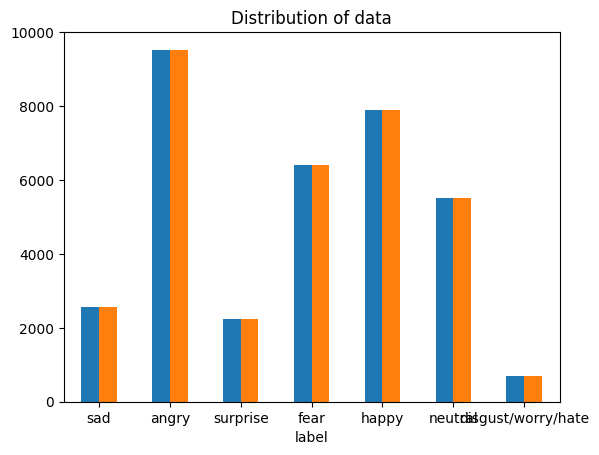

In [ ]:
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral', 'disgust/worry/hate'], rotation=0)

text, label = list(df['text']), list(df['label'])

In [ ]:
num_classes = df['label'].nunique()
print(num_classes)

7


In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'].values)

In [ ]:
#split data into training data and test data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)

(27887, 3)
(6972, 3)


In [ ]:
# Tokenize test data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text'].values), maxlen=50)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text'].values), maxlen=50)

In [ ]:
print(X_train)

[[   0    0    0 ...  874   85    2]
 [   0    0    0 ...   30    3  360]
 [   0    0    0 ...   10    7 1348]
 ...
 [   0    0    0 ...  150   12 1085]
 [   0    0    0 ...   44    5  519]
 [   0    0    0 ...   16   25  419]]


In [ ]:
print(X_train.shape)

(27887, 50)


In [ ]:
print(X_test)

[[   0    0    0 ... 2398   40 1036]
 [   0    0    0 ...   86  116  100]
 [   0    0    0 ...    9    3 1396]
 ...
 [   0    0    0 ...    0    0    7]
 [   0    0    0 ... 1556  536  148]
 [   0    0    0 ...   20    6 1358]]


In [ ]:
Y_train = train_data['label'].values
Y_test = test_data['label'].values

Y_train = to_categorical(
    Y_train, num_classes=num_classes
)
Y_test = to_categorical(
    Y_test, num_classes=num_classes
)
#print(Y_train)

In [ ]:
print(Y_train.shape)

(27887, 7)


In [ ]:
print(Y_test)

[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'angry': 0, 'disgust/worry/hate': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5, }

In [ ]:


model3 = Sequential()
model3.add(Embedding(10000, 128, input_length=X_train.shape[1]))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                          epochs=10, batch_size=128, verbose=2)

Epoch 1/10
218/218 - 30s - loss: 1.2953 - accuracy: 0.4154 - val_loss: 1.0680 - val_accuracy: 0.5108 - 30s/epoch - 139ms/step
Epoch 2/10
218/218 - 30s - loss: 0.8556 - accuracy: 0.6398 - val_loss: 0.6540 - val_accuracy: 0.7394 - 30s/epoch - 136ms/step
Epoch 3/10
218/218 - 17s - loss: 0.4848 - accuracy: 0.8052 - val_loss: 0.5340 - val_accuracy: 0.7774 - 17s/epoch - 78ms/step
Epoch 4/10
218/218 - 18s - loss: 0.3576 - accuracy: 0.8592 - val_loss: 0.5531 - val_accuracy: 0.7800 - 18s/epoch - 82ms/step
Epoch 5/10
218/218 - 18s - loss: 0.2890 - accuracy: 0.8870 - val_loss: 0.5798 - val_accuracy: 0.7735 - 18s/epoch - 84ms/step
Epoch 6/10
218/218 - 18s - loss: 0.2382 - accuracy: 0.9116 - val_loss: 0.6532 - val_accuracy: 0.7674 - 18s/epoch - 84ms/step
Epoch 7/10
218/218 - 17s - loss: 0.1883 - accuracy: 0.9320 - val_loss: 0.6867 - val_accuracy: 0.7641 - 17s/epoch - 79ms/step
Epoch 8/10
218/218 - 19s - loss: 0.1464 - accuracy: 0.9498 - val_loss: 0.8168 - val_accuracy: 0.7583 - 19s/epoch - 86ms/ste

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

In [ ]:
loss, accuracy = model3.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

218/218 [==============================] - 1s 6ms/step - loss: 0.9251 - accuracy: 0.7610
Test Loss: 0.9251328110694885
Test Accuracy: 0.7610442042350769


In [ ]:
def model_evaluate():
    # predict class with test set
    y_pred_test =  np.argmax(model3.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(Y_test,axis=1),y_pred_test)*100))

    #classification report
    print('\n')
    print(classification_report(np.argmax(Y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(Y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

218/218 [==============================] - 1s 5ms/step
Accuracy:	76.1%


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       511
           1       0.67      0.66      0.67      1919
           2       0.88      0.83      0.85       452
           3       0.93      0.94      0.93      1277
           4       0.59      0.59      0.59      1538
           5       0.94      0.92      0.93      1124
           6       0.50      0.52      0.51       151

    accuracy                           0.76      6972
   macro avg       0.76      0.76      0.76      6972
weighted avg       0.76      0.76      0.76      6972



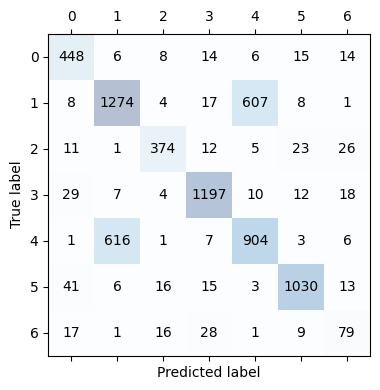

In [ ]:
model_evaluate()

In [ ]:
def predict_emotion(text):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([text])
  padded_sequence = pad_sequences(sequence, maxlen=50)
  prediction = model3.predict(padded_sequence)
  return prediction

new_text = 'This Movie was not that good'
emotion = predict_emotion(new_text)
print(f'The emotion of the review is: {emotion}')

a=np.argmax(emotion, axis=1)
label_encoder.inverse_transform(a)[0]

1/1 [==============================] - 0s 16ms/step
The emotion of the review is: [[3.0544036e-04 8.9879513e-01 5.9112113e-05 1.2790605e-04 1.0051607e-01
  1.6156740e-04 3.4592067e-05]]


'disgust/worry/hate'

In [ ]:
model3.save('Emotion_Analysis_Text.h5')